In [1]:
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

CV_flag = False
DATAPATH = "data/digits.csv"
df = pd.read_csv(DATAPATH)
X = df.drop("label",axis=1).values
y = df["label"].values
labels = df["label"] 
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
pipe = Pipeline([("scalar", MinMaxScaler()),("svm",svm.SVC(C= 1000, degree= 2, 
                                                           gamma = 0.001, kernel = 'poly'))])
pipe_grid = Pipeline([("scalar", MinMaxScaler()),("svm",svm.SVC())])    

In [ ]:
E_list = np.zeros(784)
cumsum_explained = np.zeros(784)
for i in range(1,784):
    pca = PCA(n_components = i)  # 主成分分析オブジェクトの作成
    pca.fit(X_train)                       # 主成分分析の実行
    transformed = pca.transform(X_train)   # データに対して削減後のベクトルを生成
    E = pca.explained_variance_ratio_        # 寄与率
    cumsum_explained[i] = np.cumsum(E)[::-1][0]
    if cumsum_explained[i] > 90:
        break
    print(i)
    print(cumsum_explained[i])

1
0.0972130813327733
2
0.16908145912976985
3
0.23082152615746981
4
0.2850473856889793
5
0.3332660589914497
6
0.37592914471306466
7
0.4080299207408466
8
0.43690579712784283
9
0.4651866588245605
10
0.48866863424471496
11
0.5098712800100904
12
0.5303055563422078
13
0.5478816279989553
14
0.5650423187572422
15
0.5808875958508961
16
0.5954499836458322
17
0.608690244976827
18
0.6216509621815236
19
0.6333941889293737
20
0.6450013271587534
21
0.6559302168513212
22
0.66616537866345
23
0.6759024823826654
24
0.6850670394520553
25
0.6939229457785718
26
0.7023154209204203
27
0.7105708553262278
28
0.7183852229994147
29
0.7257933623259838
30
0.7326188170785924
31
0.7393422824179228
32
0.7457892036141583
33
0.7518646125111255
34
0.7577227877865825
35
0.7633210068512148
36
0.7687151774141884
37
0.7737693144320831
38
0.7786921952314241
39
0.783479767778731
40
0.7880446960093839
41
0.7925024198943528
42
0.796921364170688


In [2]:
if CV_flag == True:
    parameters = [
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['linear']},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['rbf'], 'svm__gamma': [0.001, 0.0001]},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['poly'], 'svm__degree': [2, 3, 4], 'svm__gamma': [0.001, 0.0001]},
                {'svm__C': [1, 10, 100, 1000], 'svm__kernel': ['sigmoid'], 'svm__gamma': [0.001, 0.0001]}]
    clf = GridSearchCV(pipe_grid, param_grid=parameters,verbose=2,n_jobs=3)
    clf.fit(X_train,y_train)
    print("Best cv accuracy:{:.2f}".format(clf.best_score_))
    print("Test set score: {:.2f}".format(clf.score(X_test,y_test)))
    print("Best parameters:{}".format(clf.best_params_))
else:
    clf = pipe.fit(X_train,y_train)

C:\Users\usami\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
y_pred = clf.predict(X_test)
print(clf.score(X_test,y_test))
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

0.96
             precision    recall  f1-score   support

          0       0.97      1.00      0.98       228
          1       0.98      0.99      0.98       207
          2       0.96      0.96      0.96       201
          3       0.96      0.93      0.95       196
          4       0.93      0.97      0.95       191
          5       0.94      0.96      0.95       182
          6       0.97      0.97      0.97       186
          7       0.97      0.95      0.96       204
          8       0.96      0.95      0.96       194
          9       0.96      0.92      0.94       211

avg / total       0.96      0.96      0.96      2000

[[227   0   0   0   0   0   1   0   0   0]
 [  0 205   0   1   0   0   0   0   1   0]
 [  1   0 193   1   3   0   0   2   1   0]
 [  0   1   2 182   0   4   1   0   4   2]
 [  0   0   1   0 185   0   1   0   0   4]
 [  1   0   1   3   0 174   2   0   0   1]
 [  1   0   0   0   0   4 180   0   1   0]
 [  0   2   2   0   5   0   0 194   0   1]
 [  0   1   

In [4]:
wrong_prediction_2 = []
for counter,i in enumerate(y_test):
    if y_test[counter] == 2:
        if y_pred[counter]!=i:
            keep_list = [counter,y_pred[counter]]
            wrong_prediction_2.append(keep_list)
print(wrong_prediction_2)

[[194, 0], [530, 4], [717, 8], [722, 4], [1393, 7], [1577, 4], [1830, 7], [1964, 3]]


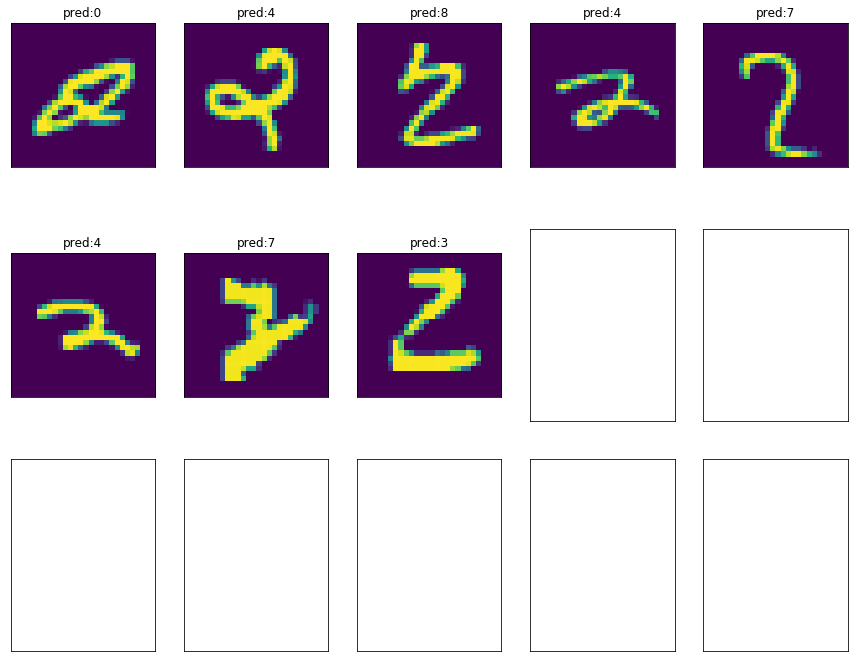

In [5]:
image_shape = [28,28]
fix, axes = plt.subplots(3,5,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction_2,axes.ravel()):
    ax.imshow(X_test[i[0]].reshape(image_shape))
    ax.set_title("pred:{}".format(i[1]))

ValueError: cannot reshape array of size 15 into shape (28,28)

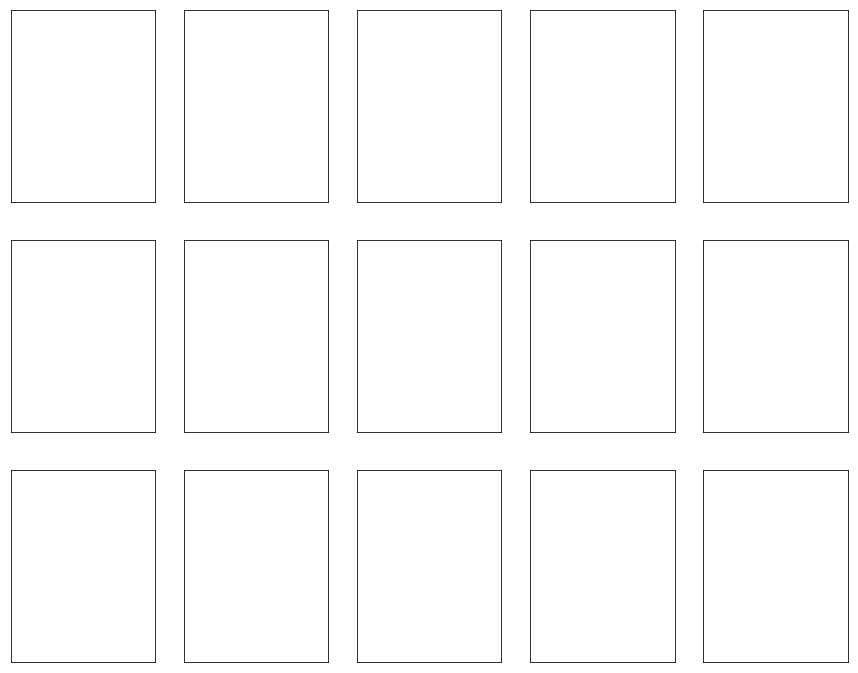

In [6]:
nmf = NMF(n_components=15,random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fix, axes = plt.subplots(3,5,figsize=(15,12),
                        subplot_kw={"xticks":(),"yticks":()})
for i,ax in zip(wrong_prediction_2,axes.ravel()):
    ax.imshow(X_test_nmf[i[0]].reshape(image_shape))
    ax.set_title("pred:{}".format(i[1]))

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import RFE
selecter_pipe = Pipeline([("scalar", MinMaxScaler()),
                         ("select",SelectFromModel(RFC(n_estimators=100,random_state=42),
                                                   threshold="median"))])
#selecter_pipe = Pipeline([("scalar", MinMaxScaler()),
#                         ("select",RFE(RFC(n_estimators=100,random_state=42),
#                                                   n_features_to_select=740,verbose=2))])

selecter_pipe.fit(X_train,y_train)

In [ ]:
X_train_l1 = selecter_pipe.transform(X_train)
print(X_train.shape)
print(X_train_l1.shape)

In [ ]:
X_test_l1 = selecter_pipe.transform(X_test)
clf_l1 = svm.SVC(C= 1000, degree= 2, 
                gamma = 0.001, kernel = 'poly').fit(X_train_l1,y_train)
score = clf_l1.score(X_test_l1,y_test)
print(score)

In [ ]:
y_pred = clf_l1.predict(X_test_l1)
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=["0","1","2","3","4","5","6","7","8","9"]))
print(metrics.confusion_matrix(y_test, y_pred, labels=range(10)))

In [ ]:
wrong_prediction_2_l1 = []
for counter,i in enumerate(y_test):
    if y_test[counter] == 2:
        if y_pred[counter]!=i:
            keep_list = [counter,y_pred[counter]]
            wrong_prediction_2_l1.append(keep_list)
print(wrong_prediction_2_l1)